In [57]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [58]:
from IPython.display import display, Markdown, Latex

In [59]:
from pathlib import Path
home = str(Path.home())

In [60]:
import sys
sys.path.insert(0,f'{home}/knowledgelib/')

In [61]:
import pyknowledge

In [62]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

In [63]:
import scipy.io
import pandas as pd
import numpy as np

mat = scipy.io.loadmat("/disk/metabric/BRCA1View20000.mat")

In [64]:
gene_labels = [g[0] for g in mat['gene'][0]]
df = pd.DataFrame(mat['data'].transpose(), columns=gene_labels)
# df['id'] = mat['id'][0]
df['target'] = mat['targets']
df['Subtype'] = df.target.map({1:'Basal',2:'HER2+',3:'LumA',4:'LumB',5:'Normal Like',6:'Normal'})
df.head()

,SCGB2A2,MUCL1,SCGB1D2,PIP,LOC648852,DNAJA2,TFF3,S100P,CPB1,CEACAM6,...,LOC645307,IL1RAP,LOC647149,LOC642453,LOC652100,LOC646050,LOC644912,LOC652294,target,Subtype
0,6.365374,5.610561,5.134799,5.735802,5.855315,5.443985,8.005882,5.615179,6.682096,5.756946,...,5.420998,5.396492,5.358751,5.424770,5.411055,5.242460,5.197767,5.643537,6,Normal
1,14.330442,7.979139,10.244240,7.138279,9.890661,11.195867,13.511164,10.548596,5.491578,6.805606,...,5.167652,5.273045,5.287980,5.398061,5.226934,5.396744,5.352158,5.811813,4,LumB
2,14.388331,6.016715,12.164435,5.272691,6.468386,5.265518,13.386034,8.764722,7.331663,11.967719,...,5.327874,5.549589,5.333051,5.368544,5.296182,5.694022,5.459744,5.269015,4,LumB
3,13.111243,7.251862,8.389121,8.664654,10.378585,5.544646,11.159766,8.263224,5.497906,5.923506,...,5.009093,5.345468,5.176322,5.326991,5.480259,5.292691,5.242160,5.635111,5,Normal Like
4,12.243103,7.293489,10.919581,9.566137,8.503568,11.492583,11.531352,9.818938,9.443134,6.889670,...,5.487783,5.479967,5.332074,5.273141,5.282872,5.222482,5.186136,5.616094,3,LumA


In [65]:
#lum_genes = pd.read_csv('metabric/Luminal_B_101/Luminal_B_101_Gene_List.csv')

#genes_df = df.loc[:,df.columns.isin(lum_genes["Gene"])]
genes_df = df.loc[:, df.columns[0:-2]]


## Here is where we would select difference scalers

In [66]:
scaler = None

if scaler is None:
    scaler = StandardScaler()
    scaler.fit(genes_df)

genes_df_scaled = pd.DataFrame(scaler.transform(genes_df),index=genes_df.index,columns=genes_df.columns).fillna(0)

In [67]:
genes_df_scaled.head()

,SCGB2A2,MUCL1,SCGB1D2,PIP,LOC648852,DNAJA2,TFF3,S100P,CPB1,CEACAM6,...,DLEU7,LOC641311,LOC645307,IL1RAP,LOC647149,LOC642453,LOC652100,LOC646050,LOC644912,LOC652294
0,-1.432453,-1.232438,-1.288245,-1.632448,-1.137374,-0.598030,-1.510784,-1.463674,-0.210238,-1.147128,...,0.135356,-0.065415,0.500807,-0.441070,1.015185,0.116970,0.469086,-0.952083,-0.724608,1.465988
1,1.190660,-0.444903,0.467094,-1.149972,0.354152,1.701203,0.766570,0.597758,-0.713243,-0.703579,...,-0.221467,-1.507060,-1.364273,-1.349882,0.494150,-0.079682,-0.886595,0.183972,0.412268,2.705125
2,1.209725,-1.097395,1.126774,-1.791766,-0.910773,-0.669370,0.714808,-0.147635,0.064210,1.479822,...,-0.697180,2.126969,-0.184749,0.686032,0.825977,-0.297008,-0.376723,2.372943,1.204494,-1.291883
3,0.789145,-0.686717,-0.170229,-0.624873,0.534497,-0.557792,-0.206126,-0.357186,-0.710569,-1.076679,...,-0.091667,-0.497581,-2.531552,-0.816703,-0.327903,-0.602948,0.978631,-0.582209,-0.397714,1.403942
4,0.503243,-0.672877,0.699107,-0.314747,-0.158539,1.819810,-0.052413,0.292870,0.956326,-0.668023,...,-0.146211,-0.719455,0.992462,0.173474,0.818781,-0.999430,-0.474728,-1.099192,-0.810255,1.263908


# First Iteration

In [116]:
# Try Binning to Generate Unequal Training and Test Distributions

# Test Size of 10%
test_size = 200 #10%

In [117]:
# Check how many of genes are from different populations

from scipy import stats 
def similarity(df1, df2):
    #print(stats.ttest_ind(df1, df2))
    return len([i for i in stats.ttest_ind(df1, df2).pvalue if i < 0.05])

In [203]:
# Bin each Gene

binned = pd.qcut(genes_df_scaled.values.reshape(191970), 10, retbins=True)[1]
binned = [-100] + list(binned[1:-1]) + [100]
genes_df_scaled_binned = pd.DataFrame()
for i in genes_df_scaled.columns:
    genes_df_scaled_binned[i] = pd.cut(genes_df_scaled[i], bins=binned).astype(str)

In [236]:
import itertools 

d = {}

for a in list(set(genes_df_scaled_binned.values.reshape(191970))):
    selected = (genes_df_scaled_binned == a).sum(axis=1).sort_values(ascending=False)[0:test_size]
    if(selected.values[-1] == 0):
        print(selected)
    test_ids = selected.index
    
    # If number of genes from different populations is close to 90, 
    # we can ensure the test set is different enough from the training set 

    s = similarity(genes_df_scaled.iloc[test_ids], genes_df_scaled.iloc[~genes_df_scaled.index.isin(test_ids)])
    if (s > 80):
        train_ids = [i for i in genes_df_scaled.index if i not in test_ids]
        d[a] = {'train_ids': list(train_ids), 'test_ids': list(test_ids)}
        


In [237]:
import json
with open("shiftedsets.json", "w") as outfile: 
    json.dump(d, outfile)

Variance of each component: [0.07170538 0.06224222 0.05201879 0.0302173  0.02337491 0.01796983
 0.01637459 0.01614625 0.01248892 0.01128121 0.01020863 0.00965848
 0.00883492 0.00849615 0.00753689 0.00626556 0.0055352  0.00520967
 0.00503875 0.0048179  0.00466151 0.00425332 0.00422964 0.00416778
 0.0039048  0.00385367 0.0035167  0.00343928 0.00336937 0.00322432
 0.00313954 0.00297925 0.0029056  0.00287385 0.00281907 0.0028118
 0.00269583 0.00261634 0.00259869 0.00253336 0.00250077 0.00242641
 0.00236629 0.0023038  0.00227346 0.00225688 0.00224459 0.00211876
 0.00209898 0.00203522 0.00201219 0.00195707 0.00190965 0.00189975
 0.0018553  0.00183613 0.00182592 0.00180426 0.00173703 0.00168023
 0.00165409 0.00164193 0.00159252 0.00157052 0.0015603  0.00151418
 0.00149736 0.00149514 0.00146644 0.00146203 0.00141162 0.00140323
 0.0013736  0.00135247 0.0013448  0.00133293 0.00131962 0.00129509
 0.00127464 0.00125429 0.00123659 0.00120797 0.00119559 0.00118907
 0.00117145 0.00116174 0.00114325 0

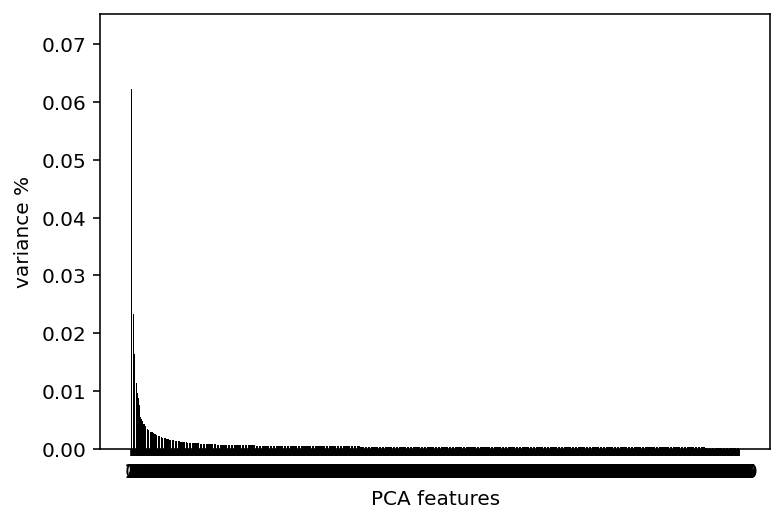

In [105]:
# shift to PCA

# Imports
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%config InlineBackend.figure_format='retina'
# Load in the data
# df = genes_df_scaled
# Standardize the data to have a mean of ~0 and a variance of 1
# X_std = StandardScaler().fit_transform(df)
# Create a PCA instance: pca
pca = PCA(n_components=1000)
principalComponents = pca.fit_transform(genes_df_scaled)
# Plot the explained variances
features = range(pca.n_components_)
plt.bar(features, pca.explained_variance_ratio_, color='black')
plt.xlabel('PCA features')
plt.ylabel('variance %')
plt.xticks(features)
# Save components to a DataFrame
PCA_components = pd.DataFrame(principalComponents)

print('Variance of each component:', pca.explained_variance_ratio_)
print('\n Total Variance Explained:', round(sum(list(pca.explained_variance_ratio_))*100, 2))

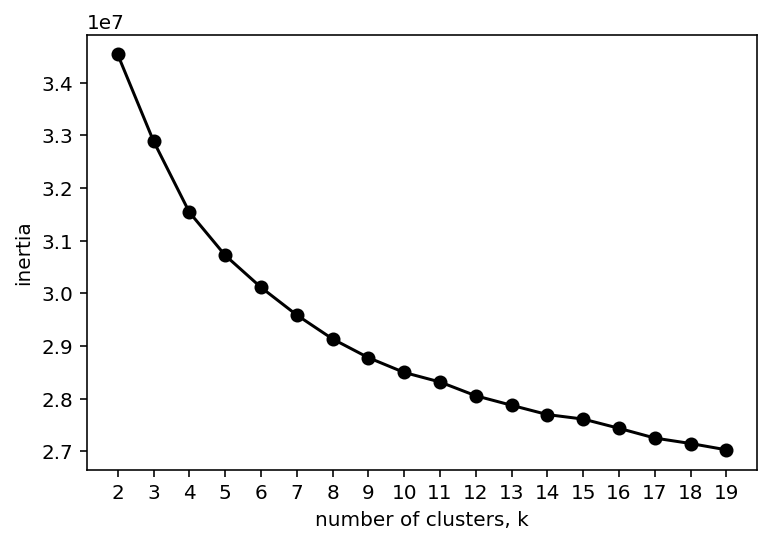

In [119]:
ks = range(2, 20)
inertias = []
from sklearn import metrics
for k in ks:
    # Create a KMeans instance with k clusters: model
    model = KMeans(n_clusters=k)
    #model = DBSCAN(eps=20, min_samples=2).fit(PCA_components)
    
    # Fit model to samples
    model.fit(PCA_components) #.iloc[:,:3])
    
    # Append the inertia to the list of inertias
    inertias.append(model.inertia_)
    
    #labels = model.labels_
    #print(np.unique(labels))
    #metrics.calinski_harabasz_score(X, labels)
    #break
    
plt.plot(ks, inertias, '-o', color='black')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.xticks(ks)
plt.show()

In [116]:

PCA_components

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,-30.776938,107.631067,-18.463343,31.152118,17.221215,13.957098,34.972593,74.703932,-23.560503,15.388598,...,-0.178439,0.761480,-0.393272,-0.217288,3.694722,-1.923909,0.523941,0.422141,2.012948,0.388703
1,11.187982,-21.935064,11.117456,5.252915,-20.007839,15.774160,32.116672,-17.384735,-6.489562,-4.576804,...,1.207844,1.490300,2.692778,-0.263281,-1.703691,2.658838,5.663856,4.497508,0.231712,-1.785744
2,21.815657,-25.244731,-37.248167,2.257492,21.533215,-20.092634,20.909065,-2.272276,-5.439191,-2.581325,...,0.529800,-1.063421,0.512452,-0.213552,0.628675,-1.199983,-0.304750,1.015378,-0.240180,1.853369
3,42.894170,-7.300614,12.514060,17.210329,7.058270,-8.073448,-0.548307,-7.929904,1.197328,3.303922,...,3.165517,-0.929061,1.823007,2.367581,-1.589073,5.512412,1.838754,-1.033174,0.463071,-0.710362
4,25.711922,-22.095183,2.062980,-10.522419,-30.916385,44.622282,20.209077,-5.732365,1.785485,-0.375442,...,1.358809,1.423474,-0.332592,2.006106,1.151643,2.907888,1.381004,-2.185411,0.266802,1.140488
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2128,8.318906,7.593492,-31.959717,-40.256406,9.199892,8.759349,12.894730,6.994893,19.796812,-12.038247,...,0.307373,3.245305,-1.182003,-1.323638,1.852500,1.932006,-0.958283,-0.620903,0.627372,0.991065
2129,1.338143,12.575880,-13.518275,-24.726429,1.853446,-1.151485,-11.229843,-4.673572,-2.232371,49.404394,...,-2.715333,2.160484,-0.310661,1.180190,0.504650,-0.125418,-0.495364,4.267313,0.579934,-1.933856
2130,-10.861082,-47.759382,-21.940772,4.472060,17.717631,1.592470,-17.708162,12.053481,40.992022,33.410855,...,1.180588,-0.969075,-1.183606,-1.175004,-3.311303,0.168849,-1.469338,0.024628,1.678722,2.598099
2131,10.099295,2.531547,-21.792816,-11.110506,4.971854,-24.538708,-12.469242,13.292408,33.649198,5.829838,...,2.193786,1.667441,-0.968678,0.067746,1.386610,0.597940,-0.737769,-1.127617,-2.470610,0.749463


In [118]:
from sklearn.cluster import DBSCAN
import numpy as np
X = PCA_components
clustering = DBSCAN(eps=0.005).fit(X)
np.unique(clustering.labels_)


array([-1])

In [35]:
import seaborn as sns
plt.figure(figsize=(16,10))
sns.scatterplot(

)

ValueError: Could not interpret value `y` for parameter `hue`

<Figure size 1152x720 with 0 Axes>